<a href="https://colab.research.google.com/github/MBdjLOTR/FOSSEE-OSDAG-Task-2-Unit-Testing/blob/main/fossee_task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

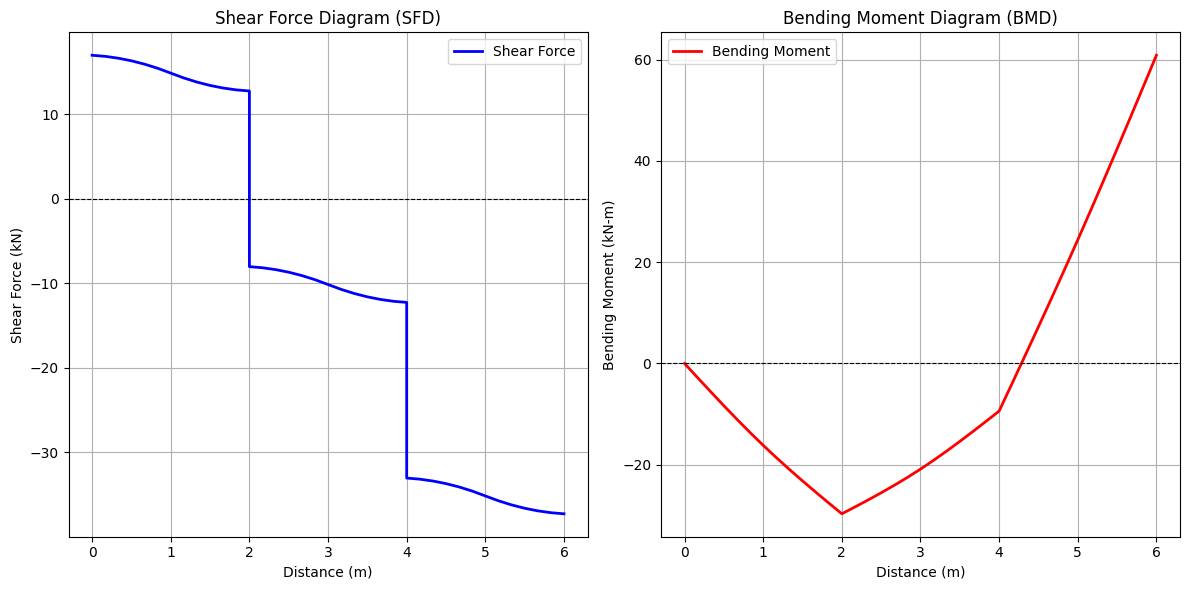

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel sheet
# Replace 'path_to_file.xlsx' with the actual file path
df = pd.read_excel("SFS_Screening_SFDBMD.xlsx")

# Extract the data from the columns
distance = df['Distance (m)']  # X-axis data
shear_force = df['SF (kN)']    # Shear Force values
bending_moment = df['BM (kN-m)']  # Bending Moment values

# Plotting the diagrams
plt.figure(figsize=(12, 6))

# Shear Force Diagram (SFD)
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.plot(distance, shear_force, label="Shear Force", color='blue', linewidth=2)
plt.title("Shear Force Diagram (SFD)")
plt.xlabel("Distance (m)")
plt.ylabel("Shear Force (kN)")
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)  # Add horizontal line at y=0
plt.grid(True)
plt.legend()

# Bending Moment Diagram (BMD)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plt.plot(distance, bending_moment, label="Bending Moment", color='red', linewidth=2)
plt.title("Bending Moment Diagram (BMD)")
plt.xlabel("Distance (m)")
plt.ylabel("Bending Moment (kN-m)")
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)  # Add horizontal line at y=0
plt.grid(True)
plt.legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [9]:
def analyze_beam(L, W1, W2, x):
    """
    Calculate beam reactions, shear forces, and bending moments for moving loads
    using influence line diagrams. Handles all edge cases.

    Parameters:
    L (float): Length of beam in meters
    W1 (float): First moving load in kN
    W2 (float): Second moving load in kN
    x (float): Distance between W1 and W2 in meters

    Returns:
    dict: Dictionary containing all required beam analysis results
    """

    # Validate inputs
    if L <= 0:
        raise ValueError("Beam length L must be greater than 0.")
    if W1 < 0 or W2 < 0:
        raise ValueError("Loads W1 and W2 must be non-negative.")
    if x < 0:
        raise ValueError("Distance x must be non-negative.")

    # Influence Line for Reaction at A (RA)
    def influence_line_RA(position):
        """
        Influence line for reaction at A.
        RA = (L - position) / L
        """
        return (L - position) / L

    # Influence Line for Reaction at B (RB)
    def influence_line_RB(position):
        """
        Influence line for reaction at B.
        RB = position / L
        """
        return position / L

    # Influence Line for Shear Force at a point (SF)
    def influence_line_SF(position, point):
        """
        Influence line for shear force at a specific point.
        SF = -position / L (for position < point)
        SF = (L - position) / L (for position >= point)
        """
        if position < point:
            return -position / L
        else:
            return (L - position) / L

    # Influence Line for Bending Moment at a point (BM)
    def influence_line_BM(position, point):
        """
        Influence line for bending moment at a specific point.
        BM = position * (L - point) / L (for position <= point)
        BM = point * (L - position) / L (for position > point)
        """
        if position <= point:
            return position * (L - point) / L
        else:
            return point * (L - position) / L

    # Handle single load case (W2 = 0)
    if W2 == 0:
        RA_max = W1
        RB_max = W1
        SF_01 = W1 * influence_line_SF(0, L / 2)
        BM_max = W1 * L / 4  # Maximum bending moment for a single load at mid-span
        z_loc = L / 2
        return {
            'Maximum Reaction at A (kN)': round(RA_max, 2),
            'Maximum Reaction at B (kN)': round(RB_max, 2),
            'Bending Moment BM_01 (kNm)': 0.0,
            'Shear Force SF_01 (kN)': round(SF_01, 2),
            'Maximum Shear Force SF_max (kN)': round(max(RA_max, RB_max), 2),
            'SF_max Location y (m)': 0.0 if RA_max > RB_max else L,
            'Maximum Bending Moment BM_max (kNm)': round(BM_max, 2),
            'BM_max Location z (m)': round(z_loc, 2)
        }

    # Handle loads beyond beam length (x > L)
    if x > L:
        x = L  # Place W2 at the end of the beam

    # Calculate maximum reactions at A and B
    RA_max = W1 * influence_line_RA(0) + W2 * influence_line_RA(x)
    RB_max = W1 * influence_line_RB(0) + W2 * influence_line_RB(x)

    # Bending moment at W1 when placed at 0m (always zero at support)
    BM_01 = 0.0

    # Shear force at mid-span (position = L/2) when W1 is at 0m
    SF_01 = W1 * influence_line_SF(0, L / 2) + W2 * influence_line_SF(x, L / 2)

    # Calculate maximum shear force and its location
    SF_max = max(RA_max, RB_max)
    y_loc = 0.0 if RA_max > RB_max else L

    # Calculate maximum bending moment and its location
    BM_max = 0.0
    z_loc = 0.0

    # Iterate through possible load positions
    step = 0.01  # Precision for numerical analysis
    for a in [i * step for i in range(int(L / step) + 1)]:
        W2_pos = a + x if a + x <= L else L  # Ensure W2 does not go beyond the beam

        # Calculate bending moment under W1
        BM_W1 = W1 * influence_line_BM(a, a) + W2 * influence_line_BM(W2_pos, a)

        # Calculate bending moment under W2
        BM_W2 = W1 * influence_line_BM(a, W2_pos) + W2 * influence_line_BM(W2_pos, W2_pos)

        # Update maximum bending moment
        current_max = max(BM_W1, BM_W2)
        if current_max > BM_max:
            BM_max = current_max
            z_loc = a if BM_W1 > BM_W2 else W2_pos

    return {
        'Maximum Reaction at A (kN)': round(RA_max, 2),
        'Maximum Reaction at B (kN)': round(RB_max, 2),
        'Bending Moment BM_01 (kNm)': round(BM_01, 2),
        'Shear Force SF_01 (kN)': round(SF_01, 2),
        'Maximum Shear Force SF_max (kN)': round(SF_max, 2),
        'SF_max Location y (m)': round(y_loc, 2),
        'Maximum Bending Moment BM_max (kNm)': round(BM_max, 2),
        'BM_max Location z (m)': round(z_loc, 2)
    }

# Example usage
if __name__ == "__main__":
    L = 15.0  # Beam length in meters
    W1 = 200.0  # kN
    W2 = 250.0  # kN
    x = 30.0  # meters between loads

    results = analyze_beam(L, W1, W2, x)
    for key, value in results.items():
        print(f"{key}: {value}")

Maximum Reaction at A (kN): 200.0
Maximum Reaction at B (kN): 250.0
Bending Moment BM_01 (kNm): 0.0
Shear Force SF_01 (kN): 0.0
Maximum Shear Force SF_max (kN): 250.0
SF_max Location y (m): 15.0
Maximum Bending Moment BM_max (kNm): 750.0
BM_max Location z (m): 7.5


In [ ]:
def analyze_beam(L, W1, W2, x):
    """
    Calculate beam reactions, shear forces, and bending moments for moving loads
    using influence line concepts.

    Parameters:
    L (float): Length of beam in meters
    W1 (float): First moving load in kN
    W2 (float): Second moving load in kN
    x (float): Distance between W1 and W2 in meters

    Returns:
    dict: Dictionary containing all required beam analysis results
    """

    # Calculate maximum reactions using influence lines
    # For maximum reaction at A (RA_max)
    if x <= L:
        RA_max = W1 + W2 * (L - x)/L
    else:
        RA_max = W1

    # For maximum reaction at B (RB_max)
    if x <= L:
        RB_max = W2 + W1 * x/L
    else:
        RB_max = W2

    # Bending moment at W1 position when placed at 0m (always zero at support)
    BM_01 = 0.0

    # Shear force at mid-span when W1 is at 0m
    if x <= L/2:
        SF_01 = -W2 * x / L
    elif x <= L:
        SF_01 = W2 * (L - x) / L
    else:
        SF_01 = 0.0

    # Maximum shear force and its location
    SF_max = max(RA_max, RB_max)
    y_loc = 0.0 if RA_max > RB_max else L

    # Calculate maximum bending moment and its location using numerical analysis
    BM_max = 0.0
    z_loc = 0.0
    step = 0.01  # Precision for numerical analysis

    # Iterate through possible load positions
    for a in [i * step for i in range(int((L - x)/step + 1))] if x <= L else []:
        W2_pos = a + x

        # Calculate reaction at A
        RA = (W1 * (L - a) + W2 * (L - W2_pos)) / L

        # Calculate bending moments under loads
        BM_under_W1 = RA * a
        BM_under_W2 = RA * W2_pos - W1 * x

        # Update maximum bending moment
        current_max = max(BM_under_W1, BM_under_W2)
        if current_max > BM_max:
            BM_max = current_max
            z_loc = a if BM_under_W1 > BM_under_W2 else W2_pos

    # Handle case when x > L
    if x > L:
        BM_max = max(W1 * L/4, W2 * L/4)  # Conservative estimate
        z_loc = L/2

    return {
        'Maximum Reaction at A (kN)': round(RA_max, 2),
        'Maximum Reaction at B (kN)': round(RB_max, 2),
        'Bending Moment BM_01 (kNm)': round(BM_01, 2),
        'Shear Force SF_01 (kN)': round(SF_01, 2),
        'Maximum Shear Force SF_max (kN)': round(SF_max, 2),
        'SF_max Location y (m)': round(y_loc, 2),
        'Maximum Bending Moment BM_max (kNm)': round(BM_max, 2),
        'BM_max Location z (m)': round(z_loc, 2)
    }

# Example usage
if __name__ == "__main__":
    L = 10.0  # Beam length in meters
    W1 = 100.0  # kN
    W2 = 150.0  # kN
    x = 5.0  # meters between loads

    results = analyze_beam(L, W1, W2, x)
    for key, value in results.items():
        print(f"{key}: {value}")

Maximum Reaction at A (kN): 175.0
Maximum Reaction at B (kN): 200.0
Bending Moment BM_01 (kNm): 0.0
Shear Force SF_01 (kN): -75.0
Maximum Shear Force SF_max (kN): 200.0
SF_max Location y (m): 10.0
Maximum Bending Moment BM_max (kNm): 400.0
BM_max Location z (m): 6.0


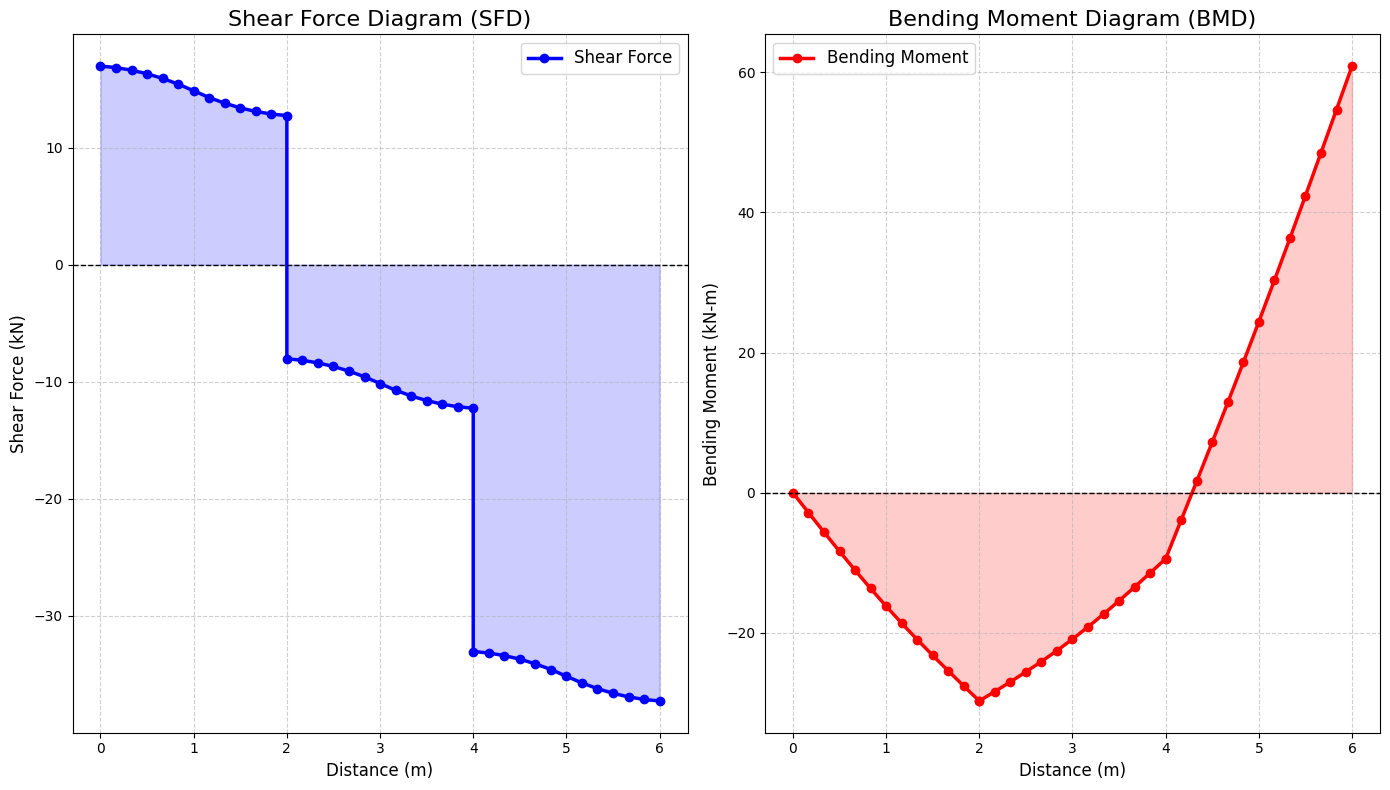

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel sheet
# Replace 'path_to_file.xlsx' with the actual file path
df = pd.read_excel("SFS_Screening_SFDBMD.xlsx")

# Extract the data from the columns
distance = df['Distance (m)']  # X-axis data
shear_force = df['SF (kN)']    # Shear Force values
bending_moment = df['BM (kN-m)']  # Bending Moment values

# Plotting the diagrams
plt.figure(figsize=(14, 8))  # Increased figure size for better visual impact

# Shear Force Diagram (SFD)
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.plot(distance, shear_force, label="Shear Force", color='blue', linewidth=2.5, marker='o', markersize=6)
plt.fill_between(distance, shear_force, color="blue", alpha=0.2)  # Add shading under the curve
plt.title("Shear Force Diagram (SFD)", fontsize=16)
plt.xlabel("Distance (m)", fontsize=12)
plt.ylabel("Shear Force (kN)", fontsize=12)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Add horizontal line at y=0
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

# Bending Moment Diagram (BMD)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plt.plot(distance, bending_moment, label="Bending Moment", color='red', linewidth=2.5, marker='o', markersize=6)
plt.fill_between(distance, bending_moment, color="red", alpha=0.2)  # Add shading under the curve
plt.title("Bending Moment Diagram (BMD)", fontsize=16)
plt.xlabel("Distance (m)", fontsize=12)
plt.ylabel("Bending Moment (kN-m)", fontsize=12)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Add horizontal line at y=0
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [ ]:
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [7]:
def analyze_beam(L, W1, W2, x):
    """
    Calculate beam reactions, shear forces, and bending moments for moving loads
    using influence line diagrams.

    Parameters:
    L (float): Length of beam in meters
    W1 (float): First moving load in kN
    W2 (float): Second moving load in kN
    x (float): Distance between W1 and W2 in meters

    Returns:
    dict: Dictionary containing all required beam analysis results
    """

    # Influence Line for Reaction at A (RA)
    def influence_line_RA(position):
        """
        Influence line for reaction at A.
        RA = (L - position) / L
        """
        return (L - position) / L

    # Influence Line for Reaction at B (RB)
    def influence_line_RB(position):
        """
        Influence line for reaction at B.
        RB = position / L
        """
        return position / L

    # Influence Line for Shear Force at a point (SF)
    def influence_line_SF(position, point):
        """
        Influence line for shear force at a specific point.
        SF = -position / L (for position < point)
        SF = (L - position) / L (for position >= point)
        """
        if position < point:
            return -position / L
        else:
            return (L - position) / L

    # Influence Line for Bending Moment at a point (BM)
    def influence_line_BM(position, point):
        """
        Influence line for bending moment at a specific point.
        BM = position * (L - point) / L (for position <= point)
        BM = point * (L - position) / L (for position > point)
        """
        if position <= point:
            return position * (L - point) / L
        else:
            return point * (L - position) / L

    # Calculate maximum reactions at A and B
    # Place W1 at support A (position = 0) and W2 at position = x
    RA_max = W1 * influence_line_RA(0) + W2 * influence_line_RA(x)
    RB_max = W1 * influence_line_RB(0) + W2 * influence_line_RB(x)

    # Bending moment at W1 when placed at 0m (always zero at support)
    BM_01 = 0.0

    # Shear force at mid-span (position = L/2) when W1 is at 0m
    SF_01 = W1 * influence_line_SF(0, L / 2) + W2 * influence_line_SF(x, L / 2)

    # Calculate maximum shear force and its location
    # Shear force is maximum at supports
    SF_max = max(RA_max, RB_max)
    y_loc = 0.0 if RA_max > RB_max else L

    # Calculate maximum bending moment and its location
    # Bending moment is maximum under one of the loads
    BM_max = 0.0
    z_loc = 0.0

    # Iterate through possible load positions
    step = 0.01  # Precision for numerical analysis
    for a in [i * step for i in range(int(L / step) + 1)]:
        W2_pos = a + x if a + x <= L else L  # Ensure W2 does not go beyond the beam

        # Calculate bending moment under W1
        BM_W1 = W1 * influence_line_BM(a, a) + W2 * influence_line_BM(W2_pos, a)

        # Calculate bending moment under W2
        BM_W2 = W1 * influence_line_BM(a, W2_pos) + W2 * influence_line_BM(W2_pos, W2_pos)

        # Update maximum bending moment
        current_max = max(BM_W1, BM_W2)
        if current_max > BM_max:
            BM_max = current_max
            z_loc = a if BM_W1 > BM_W2 else W2_pos

    return {
        'Maximum Reaction at A (kN)': round(RA_max, 2),
        'Maximum Reaction at B (kN)': round(RB_max, 2),
        'Bending Moment BM_01 (kNm)': round(BM_01, 2),
        'Shear Force SF_01 (kN)': round(SF_01, 2),
        'Maximum Shear Force SF_max (kN)': round(SF_max, 2),
        'SF_max Location y (m)': round(y_loc, 2),
        'Maximum Bending Moment BM_max (kNm)': round(BM_max, 2),
        'BM_max Location z (m)': round(z_loc, 2)
    }

# Example usage
if __name__ == "__main__":
    L = 10.0  # Beam length in meters
    W1 = 100.0  # kN
    W2 = 150.0  # kN
    x = 4.0  # meters between loads

    results = analyze_beam(L, W1, W2, x)
    for key, value in results.items():
        print(f"{key}: {value}")

Maximum Reaction at A (kN): 190.0
Maximum Reaction at B (kN): 60.0
Bending Moment BM_01 (kNm): 0.0
Shear Force SF_01 (kN): -60.0
Maximum Shear Force SF_max (kN): 190.0
SF_max Location y (m): 0.0
Maximum Bending Moment BM_max (kNm): 441.0
BM_max Location z (m): 5.8


In [ ]:
import math

def calculate_bolt_strength(bolt_grade):
    """
    Calculate the ultimate tensile strength and yield strength of the bolt based on its grade.
    :param bolt_grade: Bolt grade (e.g., 4.6, 5.6)
    :return: Tuple containing (ultimate tensile strength, yield strength) of the bolt
    """
    bolt_fu = int(bolt_grade) * 100  # Ultimate tensile strength (MPa)
    bolt_fy = (bolt_grade - int(bolt_grade)) * bolt_fu  # Yield strength (MPa)
    return bolt_fu, bolt_fy

def design_lap_joint(P, w, t1, t2):
    """
    Design a bolted lap joint connecting two plates.
    :param P: Tensile force in kN
    :param w: Width of the plates in mm
    :param t1: Thickness of plate 1 in mm
    :param t2: Thickness of plate 2 in mm
    :return: Dictionary of design parameters and results
    """
    # Convert tensile force to Newtons
    P_N = P * 1000

    # Available data
    d_list = [10, 12, 16, 20, 24]  # Bolt diameters in mm
    GB_list = [3.6, 4.6, 4.8, 5.6, 5.8]  # Bolt grades
    GP_list = [
        "E250", "E275", "E300", "E350", "E410", "E450", "E550", "E600",  # IS 2062 Grades
        "A36", "A572 GR 50", "A588", "A516 GR 70", "A514 T-1",            # ASTM Grades
        "S235", "S275", "S355", "S460",                                   # EN 10025 Grades
        "AR360", "AR400", "AR500",                                        # Abrasion-Resistant Grades
        "ABS Grade A", "ABS Grade B", "ABS Grade D",                      # Shipbuilding Grades
        "Lloyds AH32", "Lloyds EH36", "Lloyds DH36"                       # More Shipbuilding Grades
    ]
    plate_grades = {
        "E250": (250, 410), "E275": (275, 440), "E300": (300, 470),
        "E350": (350, 510), "E410": (410, 550), "E450": (450, 580),
        "E550": (550, 640), "E600": (600, 680), "A36": (250, 400),
        "A572 GR 50": (345, 450), "A588": (345, 485), "A516 GR 70": (260, 485),
        "A514 T-1": (690, 760), "S235": (235, 360), "S275": (275, 430),
        "S355": (355, 470), "S460": (460, 540), "AR360": (360, 450),
        "AR400": (400, 550), "AR500": (500, 650), "ABS Grade A": (235, 400),
        "ABS Grade B": (235, 400), "ABS Grade D": (235, 400),
        "Lloyds AH32": (315, 440), "Lloyds EH36": (355, 490), "Lloyds DH36": (355, 490)
    }

    # Select the best plate grade
    plate_grade = GP_list[-1]  # Choose the highest grade for the design
    fy_plate, fu_plate = plate_grades[plate_grade]

    # Initialize variables to store the best design
    best_design = None
    min_length = float('inf')

    for d in d_list:
        for GB in GB_list:
            # Calculate bolt properties
            bolt_fu, bolt_fy = calculate_bolt_strength(GB)

            # Calculate the shear strength of one bolt
            A_bolt = math.pi * (d / 2) ** 2  # Cross-sectional area of the bolt (mm^2)
            V_b = 0.75 * bolt_fy * A_bolt / (1e3 * 2)  # Shear capacity in kN (2 shear planes)

            # Calculate the required number of bolts
            N_b = math.ceil(P_N / (V_b * 0.75))  # Using a safety factor of 1.33

            if N_b <= 2:
                continue  # Skip if the number of bolts is less than 3

            # Calculate detailing distances
            e = max(d + 5, 20)  # End distance
            p = max(d + 10, 30)  # Pitch distance
            g = w / 2  # Gauge distance (simplified as half of plate width)

            # Calculate the length of the connection
            length_of_connection = (N_b - 1) * p + 2 * e

            # Calculate the bearing strength of the bolt
            V_dpb = 2.5 * d * (t1 + t2) * fu_plate / 1e3  # Bearing capacity in kN

            # Check utilization ratio
            connection_strength = min(N_b * V_b, N_b * V_dpb)
            utilization_ratio = P_N / connection_strength

            # Update the best design if this one is better
            if utilization_ratio <= 1 and length_of_connection < min_length:
                min_length = length_of_connection
                best_design = {
                    "bolt_diameter": d,
                    "bolt_grade": GB,
                    "number_of_bolts": N_b,
                    "pitch_distance": p,
                    "gauge_distance": g,
                    "end_distance": e,
                    "edge_distance": e,
                    "number_of_rows": 1,  # Simplified assumption
                    "number_of_columns": N_b,
                    "hole_diameter": d + 2,  # Bolt hole diameter
                    "strength_of_connection": connection_strength,
                    "yield_strength_plate_1": fy_plate,
                    "yield_strength_plate_2": fy_plate,
                    "length_of_connection": length_of_connection,
                    "efficiency_of_connection": utilization_ratio
                }

    if best_design is None:
        raise ValueError("No suitable design found that meets the requirements.")

    return best_design


# Example usage
if __name__ == "__main__":
    P = 100  # Tensile force in kN
    w = 150  # Width of the plates in mm
    t1 = 10  # Thickness of plate 1 in mm
    t2 = 12  # Thickness of plate 2 in mm

    design = design_lap_joint(P, w, t1, t2)
    for key, value in design.items():
        print(f"{key}: {value}")


bolt_diameter: 24
bolt_grade: 5.8
number_of_bolts: 1965
pitch_distance: 34
gauge_distance: 75.0
end_distance: 29
edge_distance: 29
number_of_rows: 1
number_of_columns: 1965
hole_diameter: 26
strength_of_connection: 133341.7585889651
yield_strength_plate_1: 355
yield_strength_plate_2: 355
length_of_connection: 66834
efficiency_of_connection: 0.7499526109315588


In [ ]:
!pip install pytest

In [ ]:
import math

# Constants and available options
BOLT_DIAMETERS = [10, 12, 16, 20, 24]  # Bolt diameters in mm
BOLT_GRADES = [3.6, 4.6, 4.8, 5.6, 5.8, 6.8, 8.8, 10.9]  # Bolt grades
PLATE_GRADES = ["E250", "E275", "E300", "E350", "E410", "E450", "E500", "E550"]  # Plate grades

# Mapping of plate grades to yield and ultimate strengths (fy, fu) in MPa
PLATE_STRENGTHS = {
    "E250": (250, 410),
    "E275": (275, 440),
    "E300": (300, 470),
    "E350": (350, 510),
    "E410": (410, 550),
    "E450": (450, 590),
    "E500": (500, 650),
    "E550": (550, 700),
}

# Safety factor for bolt shear capacity
SAFETY_FACTOR = 1.33  # Corresponds to 0.75 in the utilization ratio

def calculate_bolt_strength(bolt_grade):
    """
    Calculate the ultimate tensile strength (fu) and yield strength (fy) of a bolt based on its grade.
    :param bolt_grade: Bolt grade (e.g., 4.6, 5.8)
    :return: Tuple of (fu, fy) in MPa
    """
    fu = int(bolt_grade) * 100  # Ultimate tensile strength
    fy = (bolt_grade - int(bolt_grade)) * fu  # Yield strength
    return fu, fy

def calculate_shear_capacity(fy, A_bolt):
    """
    Calculate the shear capacity of a bolt as per IS 800:2007.
    :param fy: Yield strength of the bolt in MPa
    :param A_bolt: Cross-sectional area of the bolt in mm²
    :return: Shear capacity in N
    """
    # Simplified formula for shear capacity (V_b = 0.6 * fy * A_bolt)
    return 0.6 * fy * A_bolt

def calculate_bearing_capacity(fu_plate, t, d):
    """
    Calculate the bearing capacity of a bolt as per IS 800:2007.
    :param fu_plate: Ultimate strength of the plate in MPa
    :param t: Total thickness of the plates in mm
    :param d: Diameter of the bolt in mm
    :return: Bearing capacity in N
    """
    # Simplified formula for bearing capacity (V_dpb = 2.5 * fu_plate * t * d)
    return 2.5 * fu_plate * t * d

def design_lap_joint(P, w, t1, t2, plate_grade="E410"):
    """
    Design a bolted lap joint connecting two plates.
    :param P: Tensile force in kN
    :param w: Width of the plates in mm
    :param t1: Thickness of plate 1 in mm
    :param t2: Thickness of plate 2 in mm
    :param plate_grade: Grade of the steel plate (default is E410)
    :return: Dictionary of design parameters and results
    """
    P_N = P * 1000  # Convert tensile force to Newtons
    best_design = None
    min_length = float('inf')

    # Check if the plate grade is valid
    if plate_grade not in PLATE_STRENGTHS:
        raise ValueError(f"Invalid plate grade: {plate_grade}. Available grades are {list(PLATE_STRENGTHS.keys())}")

    # Get plate strengths
    fy_plate, fu_plate = PLATE_STRENGTHS[plate_grade]

    # Iterate through all combinations of bolt diameters and grades
    for d in BOLT_DIAMETERS:
        for GB in BOLT_GRADES:
            # Calculate bolt strength
            fu_bolt, fy_bolt = calculate_bolt_strength(GB)
            A_bolt = math.pi * (d / 2) ** 2  # Cross-sectional area of the bolt

            # Calculate shear capacity of one bolt
            V_b = calculate_shear_capacity(fy_bolt, A_bolt)

            # Calculate required number of bolts
            N_b = math.ceil(P_N / (V_b / SAFETY_FACTOR))

            # Skip designs with fewer than 2 bolts
            if N_b < 2:
                continue

            # Calculate detailing distances
            e = d + 5  # End distance
            p = d + 10  # Pitch distance
            g = w / 2  # Gauge distance

            # Calculate length of the connection
            length_of_connection = w + 2 * e

            # Calculate bearing capacity
            t_total = t1 + t2  # Total thickness of plates
            V_dpb = calculate_bearing_capacity(fu_plate, t_total, d)

            # Calculate utilization ratio
            utilization_ratio = P_N / (N_b * V_b / SAFETY_FACTOR)

            # Check if this design is better (minimizes length and utilization ratio <= 1)
            if utilization_ratio <= 1 and length_of_connection < min_length:
                min_length = length_of_connection
                best_design = {
                    "bolt_diameter": d,
                    "bolt_grade": GB,
                    "number_of_bolts": N_b,
                    "pitch_distance": p,
                    "gauge_distance": g,
                    "end_distance": e,
                    "edge_distance": e,
                    "number_of_rows": 1,  # Simple design assumption
                    "number_of_columns": N_b,
                    "hole_diameter": d + 2,  # Hole diameter is slightly larger than the bolt
                    "strength_of_connection": N_b * V_b / SAFETY_FACTOR,
                    "yield_strength_plate_1": fy_plate,
                    "yield_strength_plate_2": fy_plate,
                    "length_of_connection": length_of_connection,
                    "efficiency_of_connection": utilization_ratio,
                }

    if best_design is None:
        raise ValueError("No suitable design found that meets the requirements.")

    return best_design

In [ ]:
pytest tested_bolted_lap_joint.py -v

Streaming output truncated to the last 5000 lines.
    
        if best_design is None:
>           raise ValueError("No suitable design found that meets the requirements.")
E           ValueError: No suitable design found that meets the requirements.

bolted_lap_joint.py:129: ValueError

During handling of the above exception, another exception occurred:

P = 0, t1 = 20, t2 = 8, plate_grade = 'E550'

    @pytest.mark.parametrize("P", loads)
    @pytest.mark.parametrize("t1", thicknesses)
    @pytest.mark.parametrize("t2", thicknesses)
    @pytest.mark.parametrize("plate_grade", plate_grades)
    def test_minimum_bolts(P, t1, t2, plate_grade):
        """
        Test that the design_lap_joint function returns a design with at least two bolts
        for any load P, thicknesses t1, t2, and plate grade.
        """
        try:
            design = design_lap_joint(P, plate_width, t1, t2, plate_grade)
            assert design["number_of_bolts"] >= 2, f"Design with P={P} kN, t1={t1} mm,

In [ ]:
import math

def calculate_bolt_strength(bolt_grade):
    """
    Calculate the ultimate tensile strength and yield strength of the bolt based on its grade.
    :param bolt_grade: Bolt grade (e.g., 4.6, 5.6)
    :return: Tuple containing (ultimate tensile strength, yield strength) of the bolt
    """
    bolt_fu = int(bolt_grade) * 100  # Ultimate tensile strength (MPa)
    bolt_fy = (bolt_grade - int(bolt_grade)) * bolt_fu  # Yield strength (MPa)
    return bolt_fu, bolt_fy

def design_lap_joint(P, w, t1, t2):
    """
    Design a bolted lap joint connecting two plates.
    :param P: Tensile force in kN
    :param w: Width of the plates in mm
    :param t1: Thickness of plate 1 in mm
    :param t2: Thickness of plate 2 in mm
    :return: Dictionary of design parameters and results
    """
    # Convert tensile force to Newtons
    P_N = P * 1000

    # Available data
    d_list = [10, 12, 16, 20, 24]  # Bolt diameters in mm
    GB_list = [3.6, 4.6, 4.8, 5.6, 5.8]  # Bolt grades
    GP_list = [
        "E250", "E275", "E300", "E350", "E410", "E450", "E550", "E600",  # IS 2062 Grades
        "A36", "A572 GR 50", "A588", "A516 GR 70", "A514 T-1",            # ASTM Grades
        "S235", "S275", "S355", "S460",                                   # EN 10025 Grades
        "AR360", "AR400", "AR500",                                        # Abrasion-Resistant Grades
        "ABS Grade A", "ABS Grade B", "ABS Grade D",                      # Shipbuilding Grades
        "Lloyds AH32", "Lloyds EH36", "Lloyds DH36"                       # More Shipbuilding Grades
    ]
    plate_grades = {
        "E250": (250, 410), "E275": (275, 440), "E300": (300, 470),
        "E350": (350, 510), "E410": (410, 550), "E450": (450, 580),
        "E550": (550, 640), "E600": (600, 680), "A36": (250, 400),
        "A572 GR 50": (345, 450), "A588": (345, 485), "A516 GR 70": (260, 485),
        "A514 T-1": (690, 760), "S235": (235, 360), "S275": (275, 430),
        "S355": (355, 470), "S460": (460, 540), "AR360": (360, 450),
        "AR400": (400, 550), "AR500": (500, 650), "ABS Grade A": (235, 400),
        "ABS Grade B": (235, 400), "ABS Grade D": (235, 400),
        "Lloyds AH32": (315, 440), "Lloyds EH36": (355, 490), "Lloyds DH36": (355, 490)
    }

    # Select the best plate grade
    plate_grade = GP_list[-1]  # Choose the highest grade for the design
    fy_plate, fu_plate = plate_grades[plate_grade]

    # Initialize variables to store the best design
    best_design = None
    min_length = float('inf')

    for d in d_list:
        for GB in GB_list:
            # Calculate bolt properties
            bolt_fu, bolt_fy = calculate_bolt_strength(GB)

            # Calculate the shear strength of one bolt
            A_bolt = math.pi * (d / 2) ** 2  # Cross-sectional area of the bolt (mm^2)
            V_b = 0.75 * bolt_fy * A_bolt / (1e3 * 2)  # Shear capacity in kN (2 shear planes)

            # Calculate the required number of bolts
            N_b = math.ceil(P_N / (V_b * 0.75))  # Using a safety factor of 1.33

            if N_b <= 2:
                continue  # Skip if the number of bolts is less than 3

            # Calculate detailing distances
            e = max(d + 5, 20)  # End distance
            p = max(d + 10, 30)  # Pitch distance
            g = w / 2  # Gauge distance (simplified as half of plate width)

            # Calculate the length of the connection
            length_of_connection = (N_b - 1) * p + 2 * e

            # Calculate the bearing strength of the bolt
            V_dpb = 2.5 * d * (t1 + t2) * fu_plate / 1e3  # Bearing capacity in kN

            # Check utilization ratio
            connection_strength = min(N_b * V_b, N_b * V_dpb)
            utilization_ratio = P_N / connection_strength

            # Update the best design if this one is better
            if utilization_ratio <= 1 and length_of_connection < min_length:
                min_length = length_of_connection
                best_design = {
                    "bolt_diameter": d,
                    "bolt_grade": GB,
                    "number_of_bolts": N_b,
                    "pitch_distance": p,
                    "gauge_distance": g,
                    "end_distance": e,
                    "edge_distance": e,
                    "number_of_rows": 1,  # Simplified assumption
                    "number_of_columns": N_b,
                    "hole_diameter": d + 2,  # Bolt hole diameter
                    "strength_of_connection": connection_strength,
                    "yield_strength_plate_1": fy_plate,
                    "yield_strength_plate_2": fy_plate,
                    "length_of_connection": length_of_connection,
                    "efficiency_of_connection": utilization_ratio
                }

    if best_design is None:
        raise ValueError("No suitable design found that meets the requirements.")

    return best_design


# Example usage with user input
if __name__ == "__main__":
    print("=== Bolted Lap Joint Design ===")
    P = float(input("Enter the tensile force (P) in kN: "))
    w = float(input("Enter the width of the plates (w) in mm: "))
    t1 = float(input("Enter the thickness of plate 1 (t1) in mm: "))
    t2 = float(input("Enter the thickness of plate 2 (t2) in mm: "))

    try:
        design = design_lap_joint(P, w, t1, t2)
        print("\n=== Design Results ===")
        for key, value in design.items():
            print(f"{key}: {value}")
    except ValueError as e:
        print(f"Error: {e}")


=== Bolted Lap Joint Design ===
Enter the tensile force (P) in kN: 55
Enter the width of the plates (w) in mm: 200
Enter the thickness of plate 1 (t1) in mm: 15
Enter the thickness of plate 2 (t2) in mm: 10

=== Design Results ===
bolt_diameter: 24
bolt_grade: 5.8
number_of_bolts: 1081
pitch_distance: 34
gauge_distance: 100.0
end_distance: 29
edge_distance: 29
number_of_rows: 1
number_of_columns: 1081
hole_diameter: 26
strength_of_connection: 73354.9318242602
yield_strength_plate_1: 355
yield_strength_plate_2: 355
length_of_connection: 36778
efficiency_of_connection: 0.7497791713823146
